# LSTM - All Sites Training with HOBO-Only Evaluation

This notebook trains an LSTM on **all sites** (including synthetic discharge-based labels) and evaluates on a held-out validation set **V** that contains only:
- Sites with real discrete HOBO measurements
- Real samples (no ADASYN-generated sequences)
- Samples never seen during training

This tests the hypothesis: does training on synthetically-labeled discharge sites improve the model's ability to predict wet/dry status at real HOBO sites?

**Pipeline:**
```
all sequences → identify HOBO sequences → hold out 20% of HOBO → V
                                        ↘
                         remaining (all non-HOBO + 80% HOBO) → ADASYN → train
```

## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report
)
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

## Data Preprocessing

In [2]:
# Data Paths
OBS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/obs.parquet"
STATIC_PATH = "/Users/michaelmurphy/Desktop/usgs_data/static_vars.parquet"
DEGREES_PATH = "/Users/michaelmurphy/Desktop/usgs_data/degrees.parquet"

# Load datasets
static_vars_df = pd.read_parquet(STATIC_PATH)
obs_df = pd.read_parquet(OBS_PATH)
degrees = pd.read_parquet(DEGREES_PATH)

In [3]:
# Pivot and merge all data sources
static_wide = static_vars_df.pivot(
    index='NHDPlusID', columns='variable', values='value'
).reset_index()

obs_wide = obs_df.pivot_table(
    index=['NHDPlusID', 'Date'], columns='variable', values='value'
).reset_index()

merged_df = obs_wide.merge(static_wide, on='NHDPlusID', how='left')
merged_df = merged_df.merge(degrees, on='NHDPlusID', how='left')
merged_df = merged_df.sort_values(['NHDPlusID', 'Date']).ffill()

# Create discharge-based wet/dry and combine with HOBO sensor readings
DRY_THRESHOLD = 0.00014
merged_df["wetdry_discharge"] = (merged_df["Discharge_CMS"] >= DRY_THRESHOLD).astype(int)
merged_df["wetdry_final"] = merged_df["HoboWetDry0.05"].fillna(merged_df["wetdry_discharge"])

# Drop irrelevant columns
merged_df = merged_df.drop(columns=["wetdry_discharge", "FromNode", "ToNode", "Flow_Status", "HoboWetDry0.05", "Discharge_CMS"])

print("Final wet/dry distribution:")
print(merged_df["wetdry_final"].value_counts())
print(f"\nTotal sites: {merged_df['NHDPlusID'].nunique()}")

Final wet/dry distribution:
wetdry_final
1.0    125708
0.0     32895
Name: count, dtype: int64

Total sites: 215


In [4]:
# Fill remaining NaN, scale numeric features
target_col = "wetdry_final"

df = merged_df.copy()
df = df.ffill().bfill().fillna(0)

y_original = df[target_col].astype(int).values
df_numeric = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore')

scaler = StandardScaler()
scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(scaled, columns=df_numeric.columns)

df_scaled_with_label = df_scaled.copy()
df_scaled_with_label[target_col] = y_original

feature_cols = df_numeric.columns.tolist()
print(f"Features: {len(feature_cols)}, Samples: {len(df_scaled_with_label)}")

Features: 22, Samples: 158603


## Sequence Creation and HOBO Hold-Out

In [5]:
# Create 30-day sliding window sequences
seq_len = 30

def create_sequences(df, seq_len=30, target_col="wetdry_final"):
    X, y = [], []
    values = df.drop(target_col, axis=1).values
    labels = df[target_col].values
    for i in range(len(df) - seq_len):
        seq = values[i:i+seq_len]
        target = labels[i+seq_len]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled_with_label, seq_len=seq_len, target_col=target_col)
print(f"Sequences: {X.shape}, Labels: {y.shape}")
print(f"Class distribution — Wet: {int((y > 0.5).sum())}, Dry: {int((y <= 0.5).sum())}")

Sequences: (158573, 30, 22), Labels: (158573,)
Class distribution — Wet: 125708, Dry: 32865


In [6]:
# Identify sites with real HOBO measurements
hobo_sites = set(obs_df[obs_df['variable'] == 'HoboWetDry0.05']['NHDPlusID'].unique())
is_hobo = df['NHDPlusID'].isin(hobo_sites).values

# Attribute each sequence to the site of its target row (row i+seq_len)
hobo_seq_mask = np.array([is_hobo[i + seq_len] for i in range(len(X))])

X_hobo, y_hobo = X[hobo_seq_mask], y[hobo_seq_mask]
X_other, y_other = X[~hobo_seq_mask], y[~hobo_seq_mask]

print(f"HOBO-site sequences: {len(X_hobo)} ({(y_hobo > 0.5).sum()} wet, {(y_hobo <= 0.5).sum()} dry)")
print(f"Non-HOBO sequences:  {len(X_other)} ({(y_other > 0.5).sum()} wet, {(y_other <= 0.5).sum()} dry)")

# Hold out 20% of HOBO sequences as V (before ADASYN)
X_hobo_train, X_hobo_val, y_hobo_train, y_hobo_val = train_test_split(
    X_hobo, y_hobo, test_size=0.2, shuffle=True, random_state=42
)

print(f"\nHOBO train: {len(X_hobo_train)}, V (HOBO held-out): {len(X_hobo_val)}")
print(f"V class distribution — Wet: {int((y_hobo_val > 0.5).sum())}, Dry: {int((y_hobo_val <= 0.5).sum())}")

# Training data = all non-HOBO sequences + HOBO train portion
X_train_all = np.concatenate([X_other, X_hobo_train])
y_train_all = np.concatenate([y_other, y_hobo_train])

# Apply ADASYN to training data only
n, T, d = X_train_all.shape
X_flat = X_train_all.reshape(n, T * d)

adasyn = ADASYN(random_state=42)
X_flat_res, y_res = adasyn.fit_resample(X_flat, y_train_all.astype(int))
X_train_res = X_flat_res.reshape(-1, T, d)

print(f"\nTraining set before ADASYN: {np.bincount(y_train_all.astype(int))}")
print(f"Training set after ADASYN:  {np.bincount(y_res.astype(int))}")

# Convert to tensors
X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_train_tensor = torch.tensor(y_res.reshape(-1, 1), dtype=torch.float32)

# V: real, unseen, HOBO-only
V_X = torch.tensor(X_hobo_val, dtype=torch.float32)
V_y = torch.tensor(y_hobo_val.reshape(-1, 1), dtype=torch.float32)

print(f"\nTraining tensor: {X_train_tensor.shape}")
print(f"V tensor: {V_X.shape}")

HOBO-site sequences: 31602 (30585 wet, 1017 dry)
Non-HOBO sequences:  126971 (95123 wet, 31848 dry)

HOBO train: 25281, V (HOBO held-out): 6321
V class distribution — Wet: 6117, Dry: 204

Training set before ADASYN: [ 32661 119591]
Training set after ADASYN:  [119463 119591]

Training tensor: torch.Size([239054, 30, 22])
V tensor: torch.Size([6321, 30, 22])


## Model Training

In [7]:
# Split ADASYN'd training data for early stopping (NOT using V)
X_tr, X_tr_val, y_tr, y_tr_val = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, shuffle=True, random_state=42
)
print(f"Train: {X_tr.shape}, Train-val (early stopping): {X_tr_val.shape}, V (HOBO eval): {V_X.shape}")

# Define LSTM model (logits output for BCEWithLogitsLoss)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=48, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        logits = self.fc(out[:, -1, :])
        return logits

model = LSTMModel(X_train_tensor.shape[2])

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0], dtype=torch.float32))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=32, shuffle=True)
tr_val_loader = DataLoader(TensorDataset(X_tr_val, y_tr_val), batch_size=32, shuffle=False)

# Training with early stopping (monitored on train-val, NOT on V)
best_val_loss = float("inf")
best_state = None
patience = 3
wait = 0
epochs = 1

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in tr_val_loader:
            logits = model(xb)
            logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
            val_loss += criterion(logits, yb).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss={total_loss/len(train_loader):.4f} | Val Loss={val_loss/len(tr_val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict().copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)
print("Loaded best model state.")

Train: torch.Size([191243, 30, 22]), Train-val (early stopping): torch.Size([47811, 30, 22]), V (HOBO eval): torch.Size([6321, 30, 22])


/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/1 | Train Loss=0.1717 | Val Loss=0.1307
Loaded best model state.


## Evaluation on V (HOBO-Only Validation)

TRAINING VAL METRICS (all sites, includes ADASYN samples)
Accuracy:  0.9594
Precision: 0.9989
Recall:    0.9194
F1 Score:  0.9575
AUC:       0.9736

V METRICS (HOBO-only, real samples, unseen)
Accuracy:  0.6110
Precision: 1.0000
Recall:    0.5980
F1 Score:  0.7484
AUC:       0.7955

Classification Report (V):
              precision    recall  f1-score   support

         Dry      0.077     1.000     0.142       204
         Wet      1.000     0.598     0.748      6117

    accuracy                          0.611      6321
   macro avg      0.538     0.799     0.445      6321
weighted avg      0.970     0.611     0.729      6321



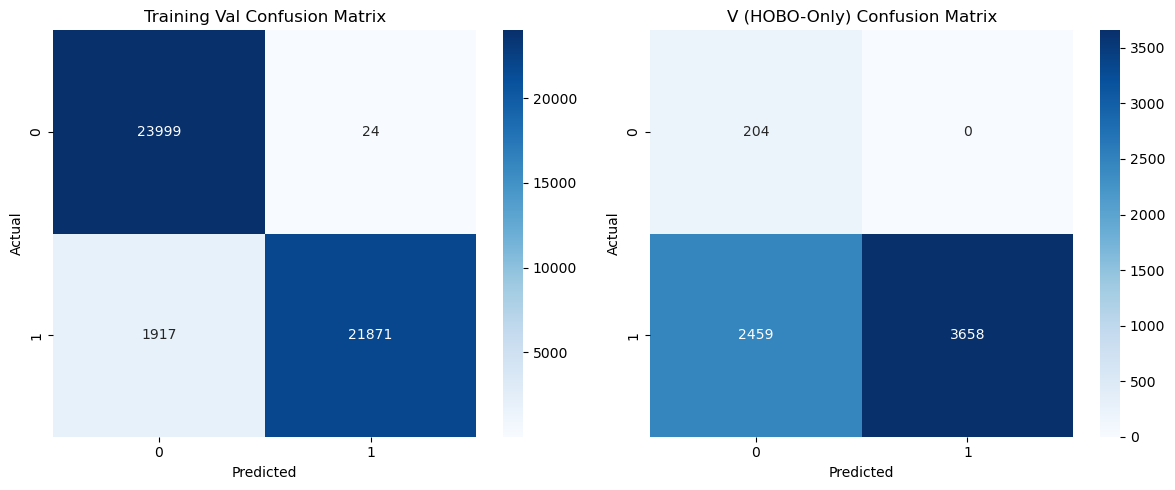

In [8]:
# Evaluate on V (HOBO-only, real samples, unseen during training)
def get_probs(model, loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            logits = torch.nan_to_num(logits, nan=0.0, posinf=15.0, neginf=-15.0)
            probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
            probs = np.nan_to_num(probs, nan=0.0, posinf=1.0, neginf=0.0)
            preds.append(probs)
            actuals.append(yb.squeeze(-1).cpu().numpy())
    return np.concatenate(preds), np.concatenate(actuals)

def compute_metrics(y_true, y_prob, y_pred):
    cm   = confusion_matrix(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float('nan')
    return cm, acc, prec, rec, f1, auc

# Training set metrics (on the held-out portion used for early stopping)
tr_val_probs, tr_val_true = get_probs(model, tr_val_loader)
tr_val_pred = (tr_val_probs >= 0.5).astype(int)
tr_val_cm, tr_val_acc, tr_val_prec, tr_val_rec, tr_val_f1, tr_val_auc = \
    compute_metrics(tr_val_true, tr_val_probs, tr_val_pred)

print("TRAINING VAL METRICS (all sites, includes ADASYN samples)")
print(f"Accuracy:  {tr_val_acc:.4f}")
print(f"Precision: {tr_val_prec:.4f}")
print(f"Recall:    {tr_val_rec:.4f}")
print(f"F1 Score:  {tr_val_f1:.4f}")
print(f"AUC:       {tr_val_auc:.4f}")

# V metrics
V_loader = DataLoader(TensorDataset(V_X, V_y), batch_size=32, shuffle=False)
v_probs, v_true = get_probs(model, V_loader)
v_pred = (v_probs >= 0.5).astype(int)

v_cm, v_acc, v_prec, v_rec, v_f1, v_auc = compute_metrics(v_true, v_probs, v_pred)

print("\nV METRICS (HOBO-only, real samples, unseen)")
print(f"Accuracy:  {v_acc:.4f}")
print(f"Precision: {v_prec:.4f}")
print(f"Recall:    {v_rec:.4f}")
print(f"F1 Score:  {v_f1:.4f}")
print(f"AUC:       {v_auc:.4f}")

print("\nClassification Report (V):")
print(classification_report(v_true, v_pred, target_names=['Dry', 'Wet'], digits=3))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(tr_val_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Training Val Confusion Matrix")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
sns.heatmap(v_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("V (HOBO-Only) Confusion Matrix")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()

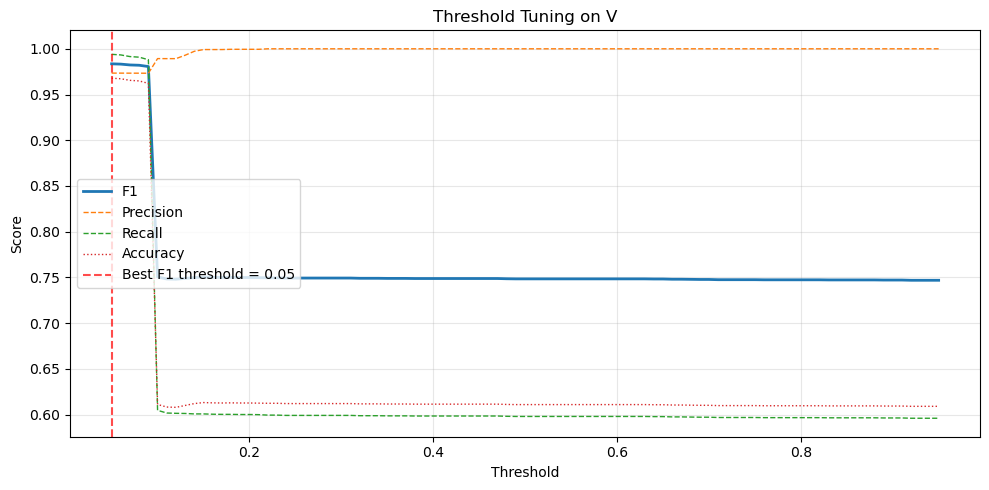

Optimal threshold: 0.05

V METRICS (threshold=0.05)
Accuracy:  0.9679
Precision: 0.9734
Recall:    0.9940
F1 Score:  0.9836
AUC:       0.7955

Classification Report (V, threshold=0.05):
              precision    recall  f1-score   support

         Dry      0.507     0.186     0.272       204
         Wet      0.973     0.994     0.984      6117

    accuracy                          0.968      6321
   macro avg      0.740     0.590     0.628      6321
weighted avg      0.958     0.968     0.961      6321



In [12]:
# Threshold tuning on V
thresholds = np.arange(0.05, 0.96, 0.01)
f1s, precisions, recalls, accuracies = [], [], [], []

for t in thresholds:
    preds_t = (v_probs >= t).astype(int)
    f1s.append(f1_score(v_true, preds_t))
    precisions.append(precision_score(v_true, preds_t, zero_division=0))
    recalls.append(recall_score(v_true, preds_t, zero_division=0))
    accuracies.append(accuracy_score(v_true, preds_t))

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, f1s, label='F1', linewidth=2)
ax.plot(thresholds, precisions, label='Precision', linewidth=1, linestyle='--')
ax.plot(thresholds, recalls, label='Recall', linewidth=1, linestyle='--')
ax.plot(thresholds, accuracies, label='Accuracy', linewidth=1, linestyle=':')
ax.axvline(best_threshold, color='red', linestyle='--', alpha=0.7, label=f'Best F1 threshold = {best_threshold:.2f}')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Tuning on V')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Metrics at optimal threshold
v_pred_opt = (v_probs >= best_threshold).astype(int)
v_cm_opt, v_acc_opt, v_prec_opt, v_rec_opt, v_f1_opt, v_auc_opt = \
    compute_metrics(v_true, v_probs, v_pred_opt)

print(f"Optimal threshold: {best_threshold:.2f}")
print(f"\nV METRICS (threshold={best_threshold:.2f})")
print(f"Accuracy:  {v_acc_opt:.4f}")
print(f"Precision: {v_prec_opt:.4f}")
print(f"Recall:    {v_rec_opt:.4f}")
print(f"F1 Score:  {v_f1_opt:.4f}")
print(f"AUC:       {v_auc_opt:.4f}")

print(f"\nClassification Report (V, threshold={best_threshold:.2f}):")
print(classification_report(v_true, v_pred_opt, target_names=['Dry', 'Wet'], digits=3))

## Feature Importance

           Feature  Importance
     aspect_sw_pct   -0.136075
          AreaSqKm   -0.132378
         In-degree    0.011813
     aspect_ne_pct    0.008745
   MaxDepth_Censor    0.007599
          LengthKM   -0.007038
       MaxDepth_cm   -0.005140
       curv_median   -0.003589
       elev_min_cm    0.002540
     aspect_se_pct    0.002533
        Out-degree    0.002326
    slp_median_pct   -0.002264
             Slope    0.001846
     aspect_nw_pct    0.001784
    elev_median_cm    0.001691
      elev_mean_cm    0.000820
       elev_max_cm   -0.000599
         curv_mean   -0.000578
      slp_mean_pct    0.000564
MaxDepth_Threshold   -0.000292
         TotDASqKm   -0.000026
        ArbolateSu    0.000000


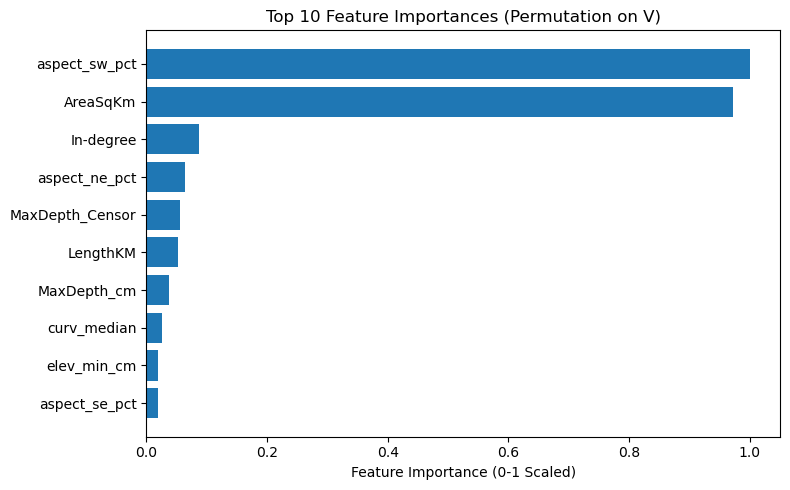

In [9]:
# Permutation importance (evaluated on V)
def perm_importance(model, X_val, y_val, n_repeats=5):
    base_preds = torch.sigmoid(model(X_val)).detach().cpu().numpy()
    base_f1 = f1_score(y_val, (base_preds > 0.5))

    importances = []
    for col in range(X_val.shape[2]):
        f1_scores = []
        for _ in range(n_repeats):
            X_permuted = X_val.clone()
            X_permuted[:, :, col] = X_val[:, :, col][torch.randperm(X_val.shape[0])]
            perm_preds = torch.sigmoid(model(X_permuted)).detach().cpu().numpy()
            f1_scores.append(f1_score(y_val, (perm_preds > 0.5)))
        importances.append(base_f1 - np.mean(f1_scores))

    return np.array(importances)

imps = perm_importance(model, V_X, V_y.squeeze().numpy())

importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": imps
})
importance['Abs_Importance'] = importance['Importance'].abs()
importance = importance.sort_values('Abs_Importance', ascending=False)
importance['Importance_Scaled'] = importance['Abs_Importance'] / importance['Abs_Importance'].max()

print(importance[['Feature', 'Importance']].to_string(index=False))

top10 = importance.head(10)
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10['Feature'][::-1], top10['Importance_Scaled'][::-1])
ax.set_xlabel('Feature Importance (0-1 Scaled)')
ax.set_title('Top 10 Feature Importances (Permutation on V)')
plt.tight_layout()
plt.show()

## Inference

In [10]:
def predict_site_date_lstm(model, scaler, site_df, seq_len, site_id, date, target_col="wetdry_final"):
    """
    Predict wet/dry status for a given site and date using LSTM.
    """
    date = pd.to_datetime(date).date()
    site_id = str(site_id)

    site_data = site_df[site_df["NHDPlusID"] == site_id].sort_values("Date")

    if site_data.empty:
        return f"No data found for Site {site_id}"

    date_idx = site_data[site_data["Date"] == date].index

    if len(date_idx) == 0:
        return f"No data found for Site {site_id} on {date}"

    date_idx = date_idx[0]
    date_pos = site_data.index.get_loc(date_idx)

    if date_pos < seq_len:
        return f"Not enough historical data (need {seq_len} days) for {date}"

    seq_data = site_data.iloc[date_pos - seq_len:date_pos]

    df_numeric = seq_data.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore')
    seq_scaled = scaler.transform(df_numeric)

    seq_tensor = torch.tensor(seq_scaled, dtype=torch.float32).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        logits = model(seq_tensor)
        prob = torch.sigmoid(logits).item()

    pred_class = 1 if prob >= 0.5 else 0

    return f"Site {site_id} on {date}: {'DRY' if pred_class == 0 else 'WET'}, (P(wet)={prob:.4f})"

In [11]:
# Example inference
predict_site_date_lstm(
    model=model,
    scaler=scaler,
    site_df=merged_df,
    seq_len=30,
    site_id="55000900272714",
    date="2020-10-18",
    target_col="wetdry_final"
)

'Site 55000900272714 on 2020-10-18: WET, (P(wet)=0.9987)'